# LLM Classification Finetuning
## Predict Human Preference using Chatbot Arena Conversations

**Goal:** Predict which model's response a judge would prefer (model_a, model_b, or tie)

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_colwidth', 200)
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the data
DATA_PATH = "llm-classification-finetuning/"

train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
sample_sub = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")

Training data shape: (57477, 9)
Test data shape: (3, 4)
Sample submission shape: (3, 4)


In [3]:
# Explore training data
print("Training Data Columns:")
print(train_df.columns.tolist())
print("\n" + "="*50)
train_df.head(2)

Training Data Columns:
['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']



,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain percentage of females on managerial positions?"",""OK, does pineapple belong on a pizza? Relax and give me fun answer.""]","[""The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, dive...","[""As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial positions is a complex one and positions can vary. Advocates argue t...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage license and marriage certificate?"",""How can I get both of them as quick as possible in California "",""What is the minimal time to get them? 1 day or 10 day...","[""A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county clerk's office or a state government, and is valid for a certain...","[""A marriage license and a marriage certificate are two different legal documents that have separate purposes.\n\n1. Marriage License: A marriage license is a legal document that gives a couple pe...",0,1,0


In [4]:
# Data info
print("Training Data Info:")
train_df.info()
print("\n" + "="*50)
print("\nMissing Values:")
print(train_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


Missing Values:
id                0
model_a           0
model_b           0
prompt            0
response_a        0
response_b        0
winner_model_a    0
winner_model_b    0
winner_tie        0
dtype: int64


Target Distribution:
Winner Model A: 20064 (34.91%)
Winner Model B: 19652 (34.19%)
Winner Tie:     17761 (30.90%)


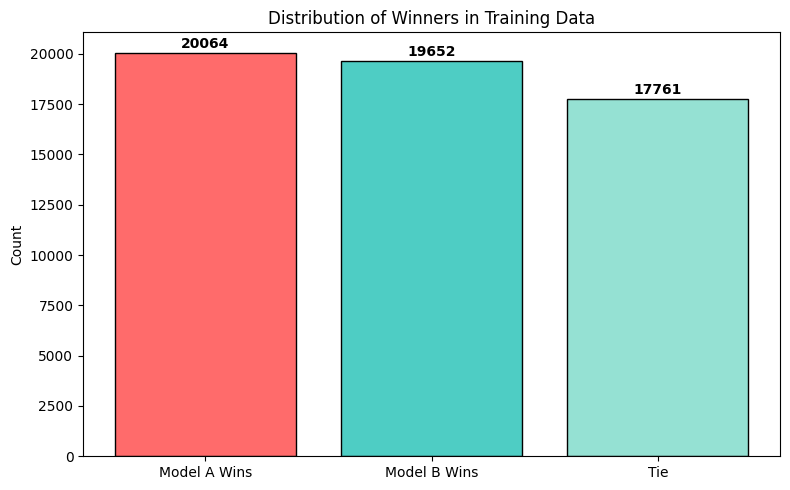

In [5]:
# Target distribution
print("Target Distribution:")
print("="*50)
print(f"Winner Model A: {train_df['winner_model_a'].sum()} ({train_df['winner_model_a'].mean()*100:.2f}%)")
print(f"Winner Model B: {train_df['winner_model_b'].sum()} ({train_df['winner_model_b'].mean()*100:.2f}%)")
print(f"Winner Tie:     {train_df['winner_tie'].sum()} ({train_df['winner_tie'].mean()*100:.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
targets = ['winner_model_a', 'winner_model_b', 'winner_tie']
counts = [train_df[t].sum() for t in targets]
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']
bars = ax.bar(['Model A Wins', 'Model B Wins', 'Tie'], counts, color=colors, edgecolor='black')
ax.set_ylabel('Count')
ax.set_title('Distribution of Winners in Training Data')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
            f'{count}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# Parse the prompt and response columns (they are stored as string representations of lists)
def safe_literal_eval(x):
    try:
        return literal_eval(x)
    except:
        return x

# Parse columns
train_df['prompt_parsed'] = train_df['prompt'].apply(safe_literal_eval)
train_df['response_a_parsed'] = train_df['response_a'].apply(safe_literal_eval)
train_df['response_b_parsed'] = train_df['response_b'].apply(safe_literal_eval)

# Check sample parsed data
print("Sample parsed prompt:")
print(train_df['prompt_parsed'].iloc[0])
print("\n" + "="*50)
print("\nSample parsed response_a:")
print(train_df['response_a_parsed'].iloc[0][:500] if isinstance(train_df['response_a_parsed'].iloc[0], list) else str(train_df['response_a_parsed'].iloc[0])[:500])

Sample parsed prompt:
['Is it morally right to try to have a certain percentage of females on managerial positions?', 'OK, does pineapple belong on a pizza? Relax and give me fun answer.']


Sample parsed response_a:
['The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations a

In [7]:
# Feature Engineering - Text lengths
def get_text_length(x):
    if isinstance(x, list):
        return sum(len(str(item)) for item in x)
    return len(str(x))

def get_num_turns(x):
    if isinstance(x, list):
        return len(x)
    return 1

train_df['prompt_length'] = train_df['prompt_parsed'].apply(get_text_length)
train_df['response_a_length'] = train_df['response_a_parsed'].apply(get_text_length)
train_df['response_b_length'] = train_df['response_b_parsed'].apply(get_text_length)
train_df['num_turns'] = train_df['prompt_parsed'].apply(get_num_turns)
train_df['length_diff'] = train_df['response_a_length'] - train_df['response_b_length']
train_df['length_ratio'] = train_df['response_a_length'] / (train_df['response_b_length'] + 1)

print("Feature Statistics:")
print(train_df[['prompt_length', 'response_a_length', 'response_b_length', 'num_turns', 'length_diff']].describe())

Feature Statistics:
       prompt_length  response_a_length  response_b_length     num_turns  \
count   57477.000000       57477.000000       57477.000000  57477.000000   
mean      352.519460        1331.340815        1338.250535      1.244219   
std      1027.246827        1462.829547        1485.219056      0.908211   
min         3.000000           0.000000           0.000000      1.000000   
25%        47.000000         391.000000         396.000000      1.000000   
50%        91.000000        1037.000000        1045.000000      1.000000   
75%       233.000000        1811.000000        1820.000000      1.000000   
max     32835.000000       53265.000000       52372.000000     36.000000   

       length_diff  
count  57477.00000  
mean      -6.90972  
std     1061.09710  
min   -51115.00000  
25%     -413.00000  
50%        0.00000  
75%      405.00000  
max    42749.00000  


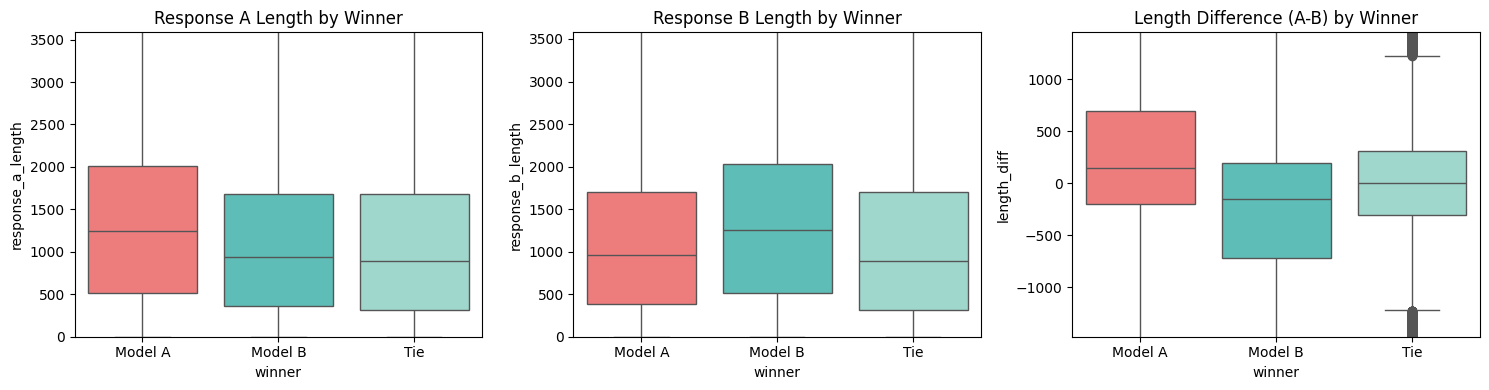

In [8]:
# Visualize response lengths by winner
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Create winner label
train_df['winner'] = train_df.apply(
    lambda x: 'Model A' if x['winner_model_a'] == 1 else ('Model B' if x['winner_model_b'] == 1 else 'Tie'), 
    axis=1
)

# Response A length by winner
sns.boxplot(data=train_df, x='winner', y='response_a_length', ax=axes[0], palette=colors)
axes[0].set_title('Response A Length by Winner')
axes[0].set_ylim(0, train_df['response_a_length'].quantile(0.95))

# Response B length by winner
sns.boxplot(data=train_df, x='winner', y='response_b_length', ax=axes[1], palette=colors)
axes[1].set_title('Response B Length by Winner')
axes[1].set_ylim(0, train_df['response_b_length'].quantile(0.95))

# Length difference by winner
sns.boxplot(data=train_df, x='winner', y='length_diff', ax=axes[2], palette=colors)
axes[2].set_title('Length Difference (A-B) by Winner')
axes[2].set_ylim(train_df['length_diff'].quantile(0.05), train_df['length_diff'].quantile(0.95))

plt.tight_layout()
plt.show()

## Text Preprocessing for Model Input

We'll create a combined text representation for each sample that includes:
- The prompt
- Response A
- Response B

This will be used as input to our transformer model.

In [9]:
def create_input_text(row):
    """
    Create formatted input text from prompt and responses.
    Format: [PROMPT] prompt_text [RESPONSE_A] response_a_text [RESPONSE_B] response_b_text
    """
    # Handle list format (multi-turn conversations)
    if isinstance(row['prompt_parsed'], list):
        prompt_text = " [TURN] ".join(str(p) for p in row['prompt_parsed'])
    else:
        prompt_text = str(row['prompt_parsed'])
    
    if isinstance(row['response_a_parsed'], list):
        response_a_text = " [TURN] ".join(str(r) for r in row['response_a_parsed'])
    else:
        response_a_text = str(row['response_a_parsed'])
        
    if isinstance(row['response_b_parsed'], list):
        response_b_text = " [TURN] ".join(str(r) for r in row['response_b_parsed'])
    else:
        response_b_text = str(row['response_b_parsed'])
    
    return f"[PROMPT] {prompt_text} [RESPONSE_A] {response_a_text} [RESPONSE_B] {response_b_text}"

# Create combined text
train_df['input_text'] = train_df.apply(create_input_text, axis=1)

# Check sample
print("Sample input text (truncated):")
print(train_df['input_text'].iloc[0][:1000] + "...")

Sample input text (truncated):
[PROMPT] Is it morally right to try to have a certain percentage of females on managerial positions? [TURN] OK, does pineapple belong on a pizza? Relax and give me fun answer. [RESPONSE_A] The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.

Here are some arguments in favor of and against such policies:

**Arguments in favor:**

1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.

2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better outcomes for organizations and soci

In [10]:
# Create target labels (0: model_a wins, 1: model_b wins, 2: tie)
train_df['label'] = train_df.apply(
    lambda x: 0 if x['winner_model_a'] == 1 else (1 if x['winner_model_b'] == 1 else 2),
    axis=1
)

print("Label distribution:")
print(train_df['label'].value_counts().sort_index())
print("\nLabel mapping: 0=Model A wins, 1=Model B wins, 2=Tie")

Label distribution:
label
0    20064
1    19652
2    17761
Name: count, dtype: int64

Label mapping: 0=Model A wins, 1=Model B wins, 2=Tie


## Model Training with Transformers

We'll use a pre-trained transformer model (DeBERTa) for this classification task. DeBERTa has shown strong performance on NLU tasks.

**Approach:**
1. Tokenize the combined text
2. Fine-tune DeBERTa for 3-class classification
3. Use cross-validation for robust evaluation

In [11]:
# Install required packages (uncomment if needed)
# !pip install transformers datasets accelerate -q

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset as HFDataset

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5060


In [12]:
# Configuration
class CFG:
    model_name = "microsoft/deberta-v3-small"  # Can change to deberta-v3-base for better performance
    max_length = 512  # Adjust based on GPU memory
    batch_size = 8
    epochs = 3
    learning_rate = 2e-5
    weight_decay = 0.01
    seed = 42
    num_labels = 3

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CFG.seed)
print(f"Model: {CFG.model_name}")
print(f"Max Length: {CFG.max_length}")
print(f"Batch Size: {CFG.batch_size}")

Model: microsoft/deberta-v3-small
Max Length: 512
Batch Size: 8


In [13]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples['input_text'],
        truncation=True,
        max_length=CFG.max_length,
        padding=False  # Will use dynamic padding with DataCollator
    )

# Create train/validation split
train_data, val_data = train_test_split(
    train_df[['input_text', 'label']], 
    test_size=0.15, 
    stratify=train_df['label'],
    random_state=CFG.seed
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

Training samples: 48855
Validation samples: 8622


In [14]:
# Clean text to remove invalid Unicode characters (surrogates)
def clean_text(text):
    """Remove invalid Unicode characters that can't be encoded in UTF-8"""
    if isinstance(text, str):
        # Encode to utf-8, replacing errors, then decode back
        return text.encode('utf-8', errors='surrogatepass').decode('utf-8', errors='replace')
    return text

# Apply cleaning to input_text column
train_data_clean = train_data.copy()
val_data_clean = val_data.copy()
train_data_clean['input_text'] = train_data_clean['input_text'].apply(clean_text)
val_data_clean['input_text'] = val_data_clean['input_text'].apply(clean_text)

# Create HuggingFace datasets
train_dataset = HFDataset.from_pandas(train_data_clean.reset_index(drop=True))
val_dataset = HFDataset.from_pandas(val_data_clean.reset_index(drop=True))

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['input_text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['input_text'])

# Rename label column
train_dataset = train_dataset.rename_column('label', 'labels')
val_dataset = val_dataset.rename_column('label', 'labels')

print("Dataset columns:", train_dataset.column_names)
print("Sample tokenized length:", len(train_dataset[0]['input_ids']))

Map: 100%|██████████| 8622/8622 [00:02<00:00, 4076.66 examples/s]

Dataset columns: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
Sample tokenized length: 512


In [15]:
# Load model and move to GPU
model = AutoModelForSequenceClassification.from_pretrained(
    CFG.model_name,
    num_labels=CFG.num_labels,
    problem_type="single_label_classification"
)

# Move model to GPU
model = model.to(device)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Compute metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    probs = torch.softmax(torch.tensor(predictions), dim=-1).numpy()
    preds = np.argmax(predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    logloss = log_loss(labels, probs, labels=[0, 1, 2])
    return {"accuracy": acc, "log_loss": logloss}

print(f"Model loaded successfully!")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model parameters: {model.num_parameters():,}")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model device: cuda:0
Model parameters: 141,897,219


In [16]:
# Training arguments - optimized for GPU
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=CFG.learning_rate,
    per_device_train_batch_size=CFG.batch_size,
    per_device_eval_batch_size=CFG.batch_size * 2,
    num_train_epochs=CFG.epochs,
    weight_decay=CFG.weight_decay,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="log_loss",
    greater_is_better=False,
    logging_steps=100,
    fp16=True,  # Enable mixed precision for faster GPU training
    dataloader_num_workers=4,  # Parallel data loading
    dataloader_pin_memory=True,  # Faster GPU transfer
    gradient_accumulation_steps=2,  # Effective batch size = 16
    report_to="none",
    seed=CFG.seed,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer initialized successfully!")
print(f"Training on: {training_args.device}")
print(f"FP16 (Mixed Precision): {training_args.fp16}")
print(f"Effective batch size: {CFG.batch_size * training_args.gradient_accumulation_steps}")

Trainer initialized successfully!
Training on: cuda:0
FP16 (Mixed Precision): True
Effective batch size: 16


In [17]:
# Clear GPU cache before training
import gc
gc.collect()
torch.cuda.empty_cache()

print(f"GPU Memory before training: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"\nStarting training...")

# Train the model
trainer.train()

print(f"\nGPU Memory after training: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")

GPU Memory before training: 0.57 GB allocated
GPU: NVIDIA GeForce RTX 5060

Starting training...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already

Epoch,Training Loss,Validation Loss,Accuracy,Log Loss,Runtime,Samples Per Second,Steps Per Second
1,1.084200,1.073227,0.408258,1.073224,49.461400,174.318000,10.897000
2,1.029900,1.035683,0.470888,1.035679,49.506900,174.158000,10.887000
3,0.978200,1.069907,0.455347,1.069909,48.122100,179.169000,11.201000


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


GPU Memory after training: 1.73 GB allocated


## Inference and Submission

Generate predictions on the test set and create submission file.

In [18]:
# Prepare test data
test_df['prompt_parsed'] = test_df['prompt'].apply(safe_literal_eval)
test_df['response_a_parsed'] = test_df['response_a'].apply(safe_literal_eval)
test_df['response_b_parsed'] = test_df['response_b'].apply(safe_literal_eval)
test_df['input_text'] = test_df.apply(create_input_text, axis=1)

print(f"Test samples: {len(test_df)}")
print("\nSample test input (truncated):")
print(test_df['input_text'].iloc[0][:500] + "...")

Test samples: 3

Sample test input (truncated):
[PROMPT] I have three oranges today, I ate an orange yesterday. How many oranges do I have? [RESPONSE_A] You have two oranges today. [RESPONSE_B] You still have three oranges. Eating an orange yesterday does not affect the number of oranges you have today....


In [19]:
def generate_predictions(model, tokenizer, texts, batch_size=16):
    """Generate predictions for test data."""
    model.eval()
    model.to(device)
    
    all_probs = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize
        inputs = tokenizer(
            batch_texts,
            truncation=True,
            max_length=CFG.max_length,
            padding=True,
            return_tensors="pt"
        ).to(device)
        
        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
            all_probs.append(probs)
        
        if (i + batch_size) % 100 == 0:
            print(f"Processed {min(i + batch_size, len(texts))}/{len(texts)} samples")
    
    return np.vstack(all_probs)

# Generate predictions (after training)
# test_predictions = generate_predictions(model, tokenizer, test_df['input_text'].tolist())

print("Prediction function defined. Run after training completes.")

Prediction function defined. Run after training completes.


In [20]:
# Create submission file
def create_submission(test_ids, predictions, output_path="submission.csv"):
    """
    Create submission file.
    predictions: numpy array of shape (n_samples, 3) with probabilities
    """
    submission = pd.DataFrame({
        'id': test_ids,
        'winner_model_a': predictions[:, 0],
        'winner_model_b': predictions[:, 1],
        'winner_tie': predictions[:, 2]
    })
    submission.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")
    return submission

# Example with dummy predictions (replace with actual predictions after training)
dummy_preds = np.full((len(test_df), 3), 1/3)  # Equal probabilities as baseline
submission = create_submission(test_df['id'].values, dummy_preds)
submission.head()

Submission saved to submission.csv


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.333333,0.333333,0.333333
1,211333,0.333333,0.333333,0.333333
2,1233961,0.333333,0.333333,0.333333


## Tips for Better Performance

1. **Larger Models**: Use `deberta-v3-base` or `deberta-v3-large` for better performance
2. **Longer Sequences**: Increase `max_length` to 1024 or 2048 if GPU memory allows
3. **Cross-Validation**: Use 5-fold stratified CV and ensemble predictions
4. **Data Augmentation**: Swap response_a and response_b with flipped labels
5. **Gradient Accumulation**: Use to simulate larger batch sizes
6. **Learning Rate Scheduling**: Try cosine annealing or linear decay
7. **Model Ensembling**: Combine predictions from multiple models (DeBERTa, Longformer, etc.)